# Question 1
Read data from patient notes.

In [3]:
#%pip install textblob
import pandas as pd
import re
#from textblob import TextBlob
#from spellchecker import SpellChecker

# Read the CSV file
df = pd.read_csv('patient_notes.csv')

# Case Conversion
df['pn_history'] = df['pn_history'].str.lower()

print(df)

       pn_num  case_num                                         pn_history
0           0         0  17-year-old male, has come to the student heal...
1           1         0  17 yo male with recurrent palpitations for the...
2           2         0  dillon cleveland is a 17 y.o. male patient wit...
3           3         0  a 17 yo m c/o palpitation started 3 mos ago; \...
4           4         0  17yo male with no pmh here for evaluation of p...
...       ...       ...                                                ...
42141   95330         9  ms. madden is a 20 yo female presenting w/ the...
42142   95331         9  a 20 yo f came complain a dull 8/10 headache t...
42143   95332         9  ms. madden is a 20yo female who presents with ...
42144   95333         9  stephanie madden is a 20 year old woman compla...
42145   95334         9  patient is a 20 yo f who presents with a heada...

[42146 rows x 3 columns]


### i. Case Conversion and iii.	Correcting Typos and Spelling
Removing Puncutation and Special Characters seems would influence standardizing formatsand handling contractions parts, so it is moved to later.

We tried the TextBlob. But after taking 17 minutes that the first 100 rows have not been handled, we plan to try some other ways.

Then I tried the symspellpy. However, it cannot be installed by conda, only can be dealt with by pip. So I move to SpaCy.

Then I found the pyspellchecker is something I must use with SpaCy and also not able to installed by conda. So I return to symspellpy.

In [4]:
#pip install symspellpy
from multiprocessing import Pool
import pandas as pd
import numpy as np
from symspellpy import SymSpell, Verbosity
import pkg_resources

# Initialize and load SymSpell
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename("symspellpy", "frequency_bigramdictionary_en_243_342.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# Function to correct spelling in a sentence
def correct_spelling(text):
    suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
    return suggestions[0].term if suggestions else text

# Function to apply correct_spelling to a Series
def apply_correct_spelling(series):
    return series.apply(correct_spelling)

# Function to parallelize
def parallelize_dataframe(df, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df_combined = pd.concat(pool.map(apply_correct_spelling, df_split))
    pool.close()
    pool.join()
    return df_combined

# Applying the function in parallel
# df_head = df.head(1000)
if __name__ == 'main':
	df['pn_history'] = parallelize_dataframe(df['pn_history'])
print(df)


/var/folders/k9/nf_fc8zd4b51my52w5q8z68m0000gn/T/ipykernel_40398/605495768.py:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


       pn_num  case_num                                         pn_history
0           0         0  17-year-old male, has come to the student heal...
1           1         0  17 yo male with recurrent palpitations for the...
2           2         0  dillon cleveland is a 17 y.o. male patient wit...
3           3         0  a 17 yo m c/o palpitation started 3 mos ago; \...
4           4         0  17yo male with no pmh here for evaluation of p...
...       ...       ...                                                ...
42141   95330         9  ms. madden is a 20 yo female presenting w/ the...
42142   95331         9  a 20 yo f came complain a dull 8/10 headache t...
42143   95332         9  ms. madden is a 20yo female who presents with ...
42144   95333         9  stephanie madden is a 20 year old woman compla...
42145   95334         9  patient is a 20 yo f who presents with a heada...

[42146 rows x 3 columns]


### 4th Standardizing Formats 5th Handling Contractions

In [5]:
# pip install inflect
# pip install contractions
import inflect
import contractions

# Create an engine for inflect
p = inflect.engine()

# Standardizing Formats "17", “17-year-old”, “3-4”, or “17yo”
def convert_numbers_in_string(s):
    # Find all numbers in the string
    numbers_in_words = re.findall(r'\b\d+\b', s)
    numbers_in_parts = re.findall(r'\d+', s)

    # For each number
    for number in numbers_in_words:
        # Convert the number to words
        word = p.number_to_words(number)
        # Replace the number with the word in the string
        s = re.sub(r'\b' + number + r'\b', word, s)

    for number in numbers_in_parts:
        # Convert the number to words
        word = p.number_to_words(number)
        # Replace the number with the word (followed by a space) in the string
        s = re.sub(number, word + " ", s)

    return s

# Handling Contractions: Expanding contractions" 
# "yo", "y.o." "y/o" to "year old",  
# "y" to "year"
# "f" to "female", 
# "m" to "male", 
# "mo" to "month", 
# "yr" to "year"
# "c/o" "c/of" "c/m" to "complains of",
# "cc" to "chief complaint"
# "h/o" to "history of"
# "pt" to "patient"
# "w", "wk" to "week", "hrs" to "hours""
# "x" to times?
def expand_contractions(text):
    # Define a dictionary of contractions and their expanded forms
    custom_contractions = {
        "yo": "year old",
        "y.o.": "year old",
        "y/o": "year old",
        "y": "year",
        "yr": "year",
        "f": "female",
        "m": "male",
        "mo": "month",
        "yr": "year",
        "c/o": "complains of",
        "c/of": "complains of",
        "c/m": "complains of",
        "cc": "chief complaint",
        "h/o": "history of",
        "pt": "patient",
        "w": "week",
        "wk": "week",
        "hrs": "hours",
        "hx": "history",
        "pmh": "past medical history",
        "pmhx": "past medical history",
        "psh": "past surgical history",
        "psurghx": "past surgical history",
        "pshh": "past surgical history",
        "meds": "medications",
        "hosp": "hosipital",
        "fh": "Family history",
        "fhx": "Family history",
        "fmh": "Family history",
        "sh":"social history",
        "soc": "social history",
        "Rx": "prescription",
        "ros":"review of systems",
        "hpi": "history of present illness"
    }

    # First, use the contractions library to expand common English contractions
    text = contractions.fix(text)

    # Then, handle the custom contractions
    # Split the text into words
    words = text.split()
    # For each word in the text
    for i in range(len(words)):
        # If the word is a contraction
        if words[i] in custom_contractions:
            # Replace the contraction with its expanded form in the text
            words[i] = custom_contractions[words[i]]
    # Join the words back into a text string
    return ' '.join(words)



def process_data(df):
    # Fill NaN values with a default value
    df.fillna('Unknown', inplace=True)
    
    # Convert columns to string type
    df['pn_history'] = df['pn_history'].astype(str)

    df['pn_history'] = df['pn_history'].apply(convert_numbers_in_string)

    # Apply the function to the 'pn_history' column
    df['pn_history'] = df['pn_history'].apply(expand_contractions)

    return df

# Apply the function to the DataFrame
df = process_data(df)

# Write the data back to the CSV file
# df.to_csv('data.csv', index=False)
print(df)

       pn_num  case_num                                         pn_history
0           0         0  seventeen-year-old male, has come to the stude...
1           1         0  seventeen year old male with recurrent palpita...
2           2         0  dillon cleveland is a seventeen year old male ...
3           3         0  a seventeen year old male complains of palpita...
4           4         0  seventeen year old male with no past medical h...
...       ...       ...                                                ...
42141   95330         9  ms. madden is a twenty year old female present...
42142   95331         9  a twenty year old female came complain a dull ...
42143   95332         9  ms. madden is a twenty year old female who pre...
42144   95333         9  stephanie madden is a twenty year old woman co...
42145   95334         9  patient is a twenty year old female who presen...

[42146 rows x 3 columns]


### 2nd. Removing Puncutation and Special Characters parts.

In [6]:
# Removing Punctuation and Special Characters
df['pn_history'] = df['pn_history'].str.replace(r'[^a-zA-Z0-9 ]', ' ', regex=True)

print(df)

       pn_num  case_num                                         pn_history
0           0         0  seventeen year old male  has come to the stude...
1           1         0  seventeen year old male with recurrent palpita...
2           2         0  dillon cleveland is a seventeen year old male ...
3           3         0  a seventeen year old male complains of palpita...
4           4         0  seventeen year old male with no past medical h...
...       ...       ...                                                ...
42141   95330         9  ms  madden is a twenty year old female present...
42142   95331         9  a twenty year old female came complain a dull ...
42143   95332         9  ms  madden is a twenty year old female who pre...
42144   95333         9  stephanie madden is a twenty year old woman co...
42145   95334         9  patient is a twenty year old female who presen...

[42146 rows x 3 columns]


### 6th. Stemming
This part would apply the stemming. I choose LancasterStemmer because it seems to be most efficient to find the root and would reduce the number of tokens, which make the last cluster easier.

In [7]:
import pandas as pd
import re
from nltk.stem import LancasterStemmer

# Read the CSV file
df = pd.read_csv('patient_notes.csv')

# Create an instance of LancasterStemmer
stemmer = LancasterStemmer()

# Apply LancasterStemmer to the pn_history column
df['pn_history'] = df['pn_history'].apply(lambda x: ' '.join([stemmer.stem(word) for word in re.findall(r'\w+', x)]))

# Print the updated dataframe
print(df)


       pn_num  case_num                                         pn_history
0           0         0  17 year old mal has com to the stud heal clin ...
1           1         0  17 yo mal with recur palpit for the past 3 mo ...
2           2         0  dillon cleveland is a 17 y o mal paty with no ...
3           3         0  a 17 yo m c o palpit start 3 mos ago noth impr...
4           4         0  17yo mal with no pmh her for evalu of palpit s...
...       ...       ...                                                ...
42141   95330         9  ms mad is a 20 yo fem pres w the worst ha of h...
42142   95331         9  a 20 yo f cam complain a dul 8 10 headach that...
42143   95332         9  ms mad is a 20yo fem who pres with a headach o...
42144   95333         9  stephany mad is a 20 year old wom complain of ...
42145   95334         9  paty is a 20 yo f who pres with a headach she ...

[42146 rows x 3 columns]


### 6th. Lemmatizer
Apply lemmatizer.

In [8]:
import nltk

nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
df['pn_history'] = df['pn_history'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in re.findall(r'\w+', x)]))
print(df)

[nltk_data] Downloading package wordnet to /Users/caoyun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


       pn_num  case_num                                         pn_history
0           0         0  17 year old mal ha com to the stud heal clin c...
1           1         0  17 yo mal with recur palpit for the past 3 mo ...
2           2         0  dillon cleveland is a 17 y o mal paty with no ...
3           3         0  a 17 yo m c o palpit start 3 mo ago noth impro...
4           4         0  17yo mal with no pmh her for evalu of palpit s...
...       ...       ...                                                ...
42141   95330         9  m mad is a 20 yo fem pres w the worst ha of he...
42142   95331         9  a 20 yo f cam complain a dul 8 10 headach that...
42143   95332         9  m mad is a 20yo fem who pres with a headach of...
42144   95333         9  stephany mad is a 20 year old wom complain of ...
42145   95334         9  paty is a 20 yo f who pres with a headach she ...

[42146 rows x 3 columns]


### 7th. Stop list
Apply a stop word list to filter out unnecessary words.

In [9]:
from nltk.corpus import stopwords

# Download the stopwords if not already present
nltk.download('stopwords')

# Get the list of stopwords
stop_words = set(stopwords.words('english'))

# Apply stop word filtering to the pn_history column
df['pn_history'] = df['pn_history'].apply(lambda x: ' '.join([word for word in re.findall(r'\w+', x) if word not in stop_words]))

# Print the updated dataframe
print(df)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/caoyun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


       pn_num  case_num                                         pn_history
0           0         0  17 year old mal ha com stud heal clin complain...
1           1         0  17 yo mal recur palpit past 3 mo last 3 4 min ...
2           2         0  dillon cleveland 17 mal paty sign pmh pres com...
3           3         0  17 yo c palpit start 3 mo ago noth improv exac...
4           4         0  17yo mal pmh evalu palpit stat last 3 4mo ha f...
...       ...       ...                                                ...
42141   95330         9  mad 20 yo fem pres w worst ha lif unlik anyth ...
42142   95331         9  20 yo f cam complain dul 8 10 headach assocy n...
42143   95332         9  mad 20yo fem pres headach 1 day dur wok yester...
42144   95333         9  stephany mad 20 year old wom complain headach ...
42145   95334         9  paty 20 yo f pres headach said ha nev somethig...

[42146 rows x 3 columns]


# Question 2
### a.CountVectorizer
Use CountVectorizer.

In [10]:
#conda install -c conda-forge scikit-learn
#pip install -U scikit-learn
from sklearn.feature_extraction.text import CountVectorizer

# Create an instance of CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the "pn_history" column
dtm = vectorizer.fit_transform(df['pn_history'])

# Convert the DTM to a DataFrame
dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

# Display the DTM DataFrame
print(dtm_df)


       00  000  0000  00am  00amto4  00h  00pm  01  01pack  02  ...  zero  \
0       0    0     0     0        0    0     0   0       0   0  ...     0   
1       0    0     0     0        0    0     0   0       0   0  ...     0   
2       0    0     0     0        0    0     0   0       0   0  ...     0   
3       0    0     0     0        0    0     0   0       0   0  ...     0   
4       0    0     0     0        0    0     0   0       0   0  ...     0   
...    ..  ...   ...   ...      ...  ...   ...  ..     ...  ..  ...   ...   
42141   0    0     0     0        0    0     0   0       0   0  ...     0   
42142   0    0     0     0        0    0     0   0       0   0  ...     0   
42143   0    0     0     0        0    0     0   0       0   0  ...     0   
42144   0    0     0     0        0    0     0   0       0   0  ...     0   
42145   0    0     0     0        0    0     0   0       0   0  ...     0   

       zex  zig  ziminopril  zno  zo  zolpidem  zon  zyb  zzz  
0        0 

### a.TfidfVectorizer
Use TfidfVectorizer

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the "pn_history" column
dtm_tfidf = vectorizer.fit_transform(df['pn_history'])

# Convert the DTM to a DataFrame
dtm_tfidf_df = pd.DataFrame(dtm_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Display the TF-IDF DTM DataFrame
print(dtm_tfidf_df)


        00  000  0000  00am  00amto4  00h  00pm   01  01pack   02  ...  zero  \
0      0.0  0.0   0.0   0.0      0.0  0.0   0.0  0.0     0.0  0.0  ...   0.0   
1      0.0  0.0   0.0   0.0      0.0  0.0   0.0  0.0     0.0  0.0  ...   0.0   
2      0.0  0.0   0.0   0.0      0.0  0.0   0.0  0.0     0.0  0.0  ...   0.0   
3      0.0  0.0   0.0   0.0      0.0  0.0   0.0  0.0     0.0  0.0  ...   0.0   
4      0.0  0.0   0.0   0.0      0.0  0.0   0.0  0.0     0.0  0.0  ...   0.0   
...    ...  ...   ...   ...      ...  ...   ...  ...     ...  ...  ...   ...   
42141  0.0  0.0   0.0   0.0      0.0  0.0   0.0  0.0     0.0  0.0  ...   0.0   
42142  0.0  0.0   0.0   0.0      0.0  0.0   0.0  0.0     0.0  0.0  ...   0.0   
42143  0.0  0.0   0.0   0.0      0.0  0.0   0.0  0.0     0.0  0.0  ...   0.0   
42144  0.0  0.0   0.0   0.0      0.0  0.0   0.0  0.0     0.0  0.0  ...   0.0   
42145  0.0  0.0   0.0   0.0      0.0  0.0   0.0  0.0     0.0  0.0  ...   0.0   

       zex  zig  ziminopril  zno   zo  

### a.n-gram
After studying the n-gram, I think we could try to find gram from bigger to smaller.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk

# Load your CSV file
# Assuming the CSV has a column 'patient_notes' with the text data
patient_notes = df['pn_history'].astype(str)

# Optional: Download NLTK stopwords
# stop_words = set(stopwords.words('english'))

# Initialize CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 4), stop_words=stopwords.words('english'))

# Fit and transform the patient notes
X = vectorizer.fit_transform(patient_notes)

# Convert to DataFrame for better readability (optional)
dtm = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Now dtm is your document-term matrix with unigrams, bigrams, trigrams, and 4-grams
print(dtm.head())


   00  00 00  00 00 ha  00 00 ha wak  00 14  00 14 00  00 14 00 ro  00 4am  \
0   0      0         0             0      0         0            0       0   
1   0      0         0             0      0         0            0       0   
2   0      0         0             0      0         0            0       0   
3   0      0         0             0      0         0            0       0   
4   0      0         0             0      0         0            0       0   

   00 4am excess  00 4am excess caffy  ...  zon rady oth  zon rady oth part  \
0              0                    0  ...             0                  0   
1              0                    0  ...             0                  0   
2              0                    0  ...             0                  0   
3              0                    0  ...             0                  0   
4              0                    0  ...             0                  0   

   zyb  zyb ndka  zyb ndka fh  zyb ndka fh fath  zzz  zz

# Question 3

In [13]:
# conda install matplotlib
# conda isntall seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [39]:
#pip install hdbscan
import hdbscan
from hdbscan import HDBSCAN
from joblib import Memory
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(dtm_df.head(1000))
HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=True, leaf_size=40, memory=Memory(None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None)

HDBSCAN(gen_min_span_tree=True)

<Axes: >

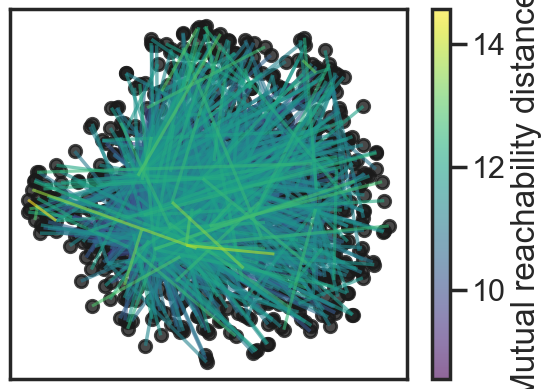

In [33]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

<Axes: ylabel='distance'>

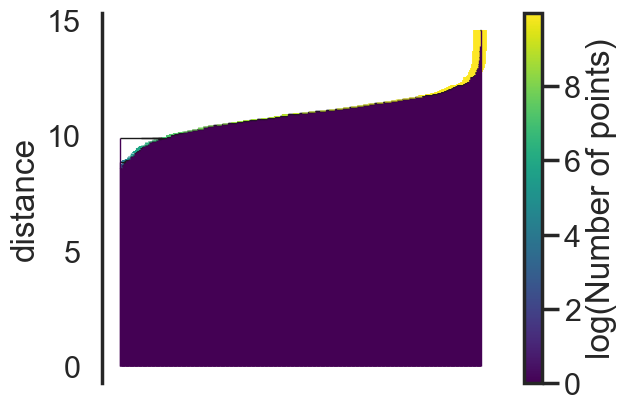

In [34]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)


<Axes: ylabel='$\\lambda$ value'>

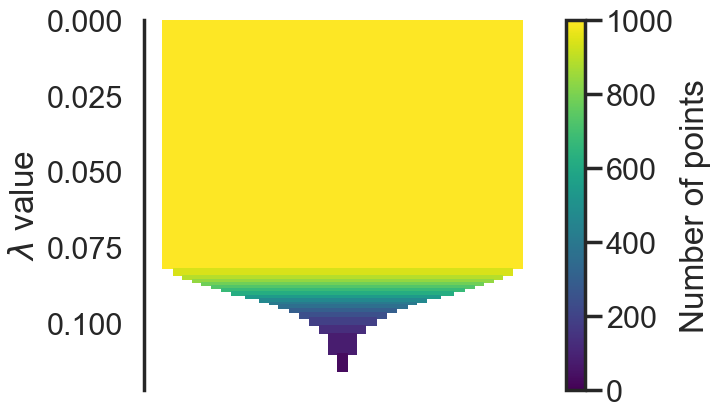

In [35]:
clusterer.condensed_tree_.plot()

<Axes: ylabel='$\\lambda$ value'>

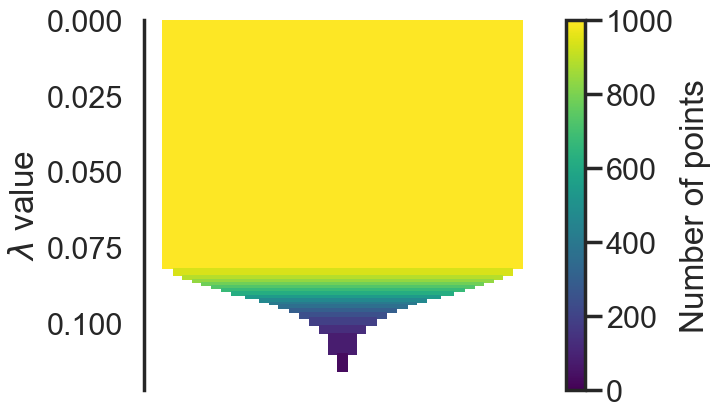

In [36]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

ValueError: 'c' argument has 1000 elements, which is inconsistent with 'x' and 'y' with size 100.

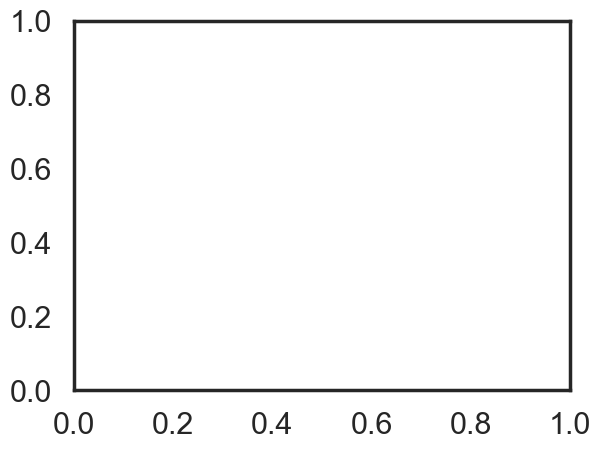

In [37]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(test_data.T[0], test_data.T[1], c=cluster_colors, **plot_kwds)